In [1]:
from datasets.noised import NoisedBayerDataset
from transforms.noising import GaussianNoise
from transforms.noising import RawNoiseBayer

In [2]:
val_bayer_noised_data_dir = "/home/safin/datasets/lfw/lfw-sphereface_noised_bayer/"
val_clean_data_dir = "/home/safin/datasets/lfw/lfw-sphereface/"

In [3]:
import torchvision
from torchvision import transforms
transform = transforms.ToTensor()
dataset_bayer_noised_val = torchvision.datasets.ImageFolder(val_bayer_noised_data_dir, transform=transform)
dataset_clean_val = torchvision.datasets.ImageFolder(val_clean_data_dir, transform=transform)

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import math, random
from PIL import Image


def bilinear(y):
    r""" Initialize with bilinear interpolation"""
    F_r = torch.FloatTensor([[1,2,1],[2,4,2],[1,2,1]])/4
    F_b = F_r
    F_g = torch.FloatTensor([[0,1,0],[1,4,1],[0,1,0]])/4
    bilinear_filter = torch.stack([F_r,F_g,F_b])[:,None]
    if y.is_cuda:
        bilinear_filter = bilinear_filter.cuda()
    res = F.conv2d(y, bilinear_filter,padding=1, groups=3)
    return res

def linrgb_to_srgb(img):
    """ Convert linRGB color space to sRGB 
        https://en.wikipedia.org/wiki/SRGB
    """
    assert img.dtype in [np.float32, np.float64] 
    img = img.copy()
    mask = img <= 0.0031308
    img[~mask] = (img[~mask]**(1/2.4))*(1.055) - 0.055
    img[mask] = img[mask] * 12.92
    return img

def srgb_to_linrgb(img):
    """ Convert sRGB color space to linRGB 
        https://en.wikipedia.org/wiki/SRGB
    """
    assert img.dtype in [np.float32, np.float64] 
    img = img.copy()
    mask = img <= 0.04045
    img[~mask] = ((img[~mask]+0.055)/1.055)**2.4
    img[mask] = img[mask] / 12.92
    return img

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline


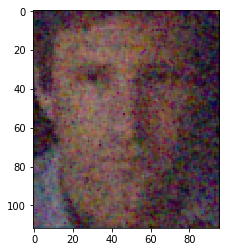

In [9]:
plt.imshow(linrgb_to_srgb(bilinear(dataset_val[2][0].unsqueeze(0)).squeeze(0).permute(1,2,0).numpy()))


In [6]:
import numpy as np
lfw_idx = np.load("/home/safin/datasets/lfw/noised_indx.npy")

In [7]:
from MMNet_TBPTT import *
from networks.denoise.pydl import ResNet_Den
import torch 
from utils import freeze_model

denoiser = ResNet_Den(5, weightnorm=True)
denoiser = denoiser.cuda()
freeze_model(denoiser)

max_iter = 5
mmnet = MMNet(denoiser, max_iter=max_iter)
# mmnet_ckpt_path = "/home/safin/ms-thesis/ckpt/joint_15.04_dnfr/denoiser/weights_10"
mmnet_ckpt_path = "/home/safin/ms-thesis/ckpt/20.04_resdnet_5it/denoiser/weights_200"
mmnet.load_state_dict(torch.load(mmnet_ckpt_path, map_location=lambda storage, loc: storage))
mmnet = mmnet.cuda()

torch.backends.cudnn.benchmark = True 

In [8]:
denoiser_joint = ResNet_Den(5, weightnorm=True)
denoiser_joint = denoiser_joint.cuda()
freeze_model(denoiser_joint)
max_iter = 10
mmnet_joint = MMNet(denoiser_joint, max_iter=max_iter)
# mmnet_ckpt_path = "/home/safin/ms-thesis/ckpt/joint_15.04_dnfr/denoiser/weights_10"
mmnet_ckpt_path = "/home/safin/FaceReID/ckpt/joint_20.04/mmnet/weights_38"
mmnet_joint.load_state_dict(torch.load(mmnet_ckpt_path, map_location=lambda storage, loc: storage))
mmnet_joint = mmnet_joint.cuda()

In [9]:
def generate_mask(im_shape, pattern='RGGB'):
    if pattern == 'RGGB':
        # pattern RGGB
        r_mask = torch.zeros(im_shape)
        r_mask[0::2, 0::2] = 1

        g_mask = torch.zeros(im_shape)
        g_mask[::2, 1::2] = 1
        g_mask[1::2, ::2] = 1

        b_mask = torch.zeros(im_shape)
        b_mask[1::2, 1::2] = 1

        mask = torch.zeros(im_shape + (3,))
        mask[:, :, 0] = r_mask
        mask[:, :, 1] = g_mask
        mask[:, :, 2] = b_mask
        
        return mask
M = generate_mask((112, 96), pattern='RGGB').permute(2,0,1).unsqueeze(0).cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AVG PSNR = 20.0935


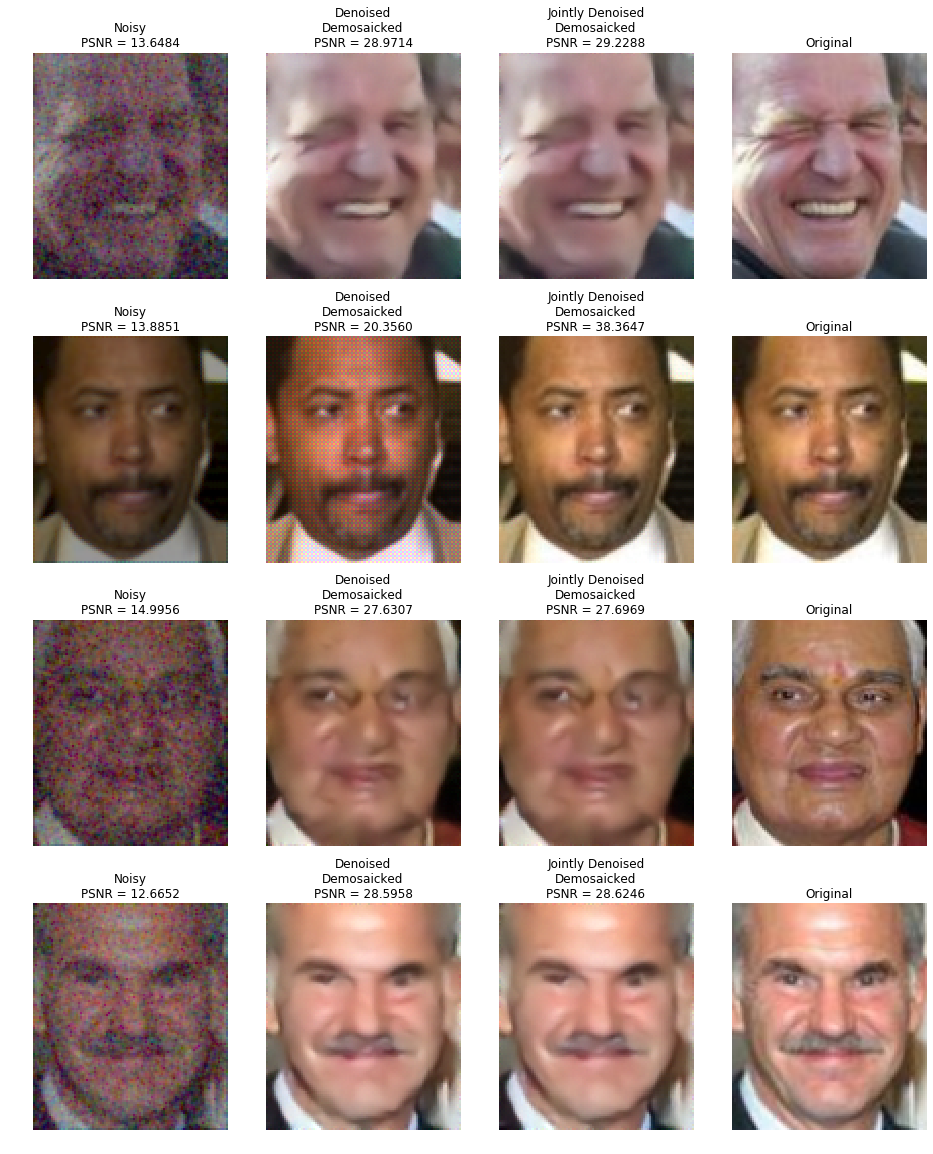

In [10]:
from loss import PSNR

fig_w = 16
fig_h = 20
fig=plt.figure(figsize=(fig_w, fig_h))
rows = 4
columns = 4

psnr_arr = []
for i in range(rows):
    cur_idx = lfw_idx[i]

    imgs_bayer_noisy, _ = dataset_bayer_noised_val[cur_idx]
    A_bayer_noisy = linrgb_to_srgb(bilinear(imgs_bayer_noisy.unsqueeze(0)).squeeze(0).permute(1,2,0).numpy())
    A_clean = dataset_clean_val[cur_idx][0].permute(1,2,0).numpy()
    denoiser_out = mmnet.forward_all_iter(255*imgs_bayer_noisy.unsqueeze(0).cuda(), M, init=False, noise_estimation=True).cpu()
    denoiser_out = denoiser_out.data.squeeze(0).permute(1,2,0).numpy()/255
    
    denoiser_joint_out = mmnet_joint.forward_all_iter(255*imgs_bayer_noisy.unsqueeze(0).cuda(), M, init=False, noise_estimation=True).cpu()
    denoiser_joint_out = denoiser_joint_out.data.squeeze(0).permute(1,2,0).numpy()/255
    
    fig.add_subplot(rows, columns, 1+i*columns)
    plt.imshow(A_bayer_noisy)
    plt.axis('off')
    cur_psnr = PSNR(torch.from_numpy(A_bayer_noisy).unsqueeze(0), torch.from_numpy(A_clean).unsqueeze(0))
#         cur_psnr = psnr(torch.from_numpy(noised).unsqueeze(0), torch.from_numpy(gt).unsqueeze(0), 1.)
    psnr_arr.append(cur_psnr)
    plt.title("Noisy\nPSNR = %.4f" % cur_psnr)
    
    fig.add_subplot(rows, columns, 1+i*columns+1)
    plt.imshow(denoiser_out/0.6)
    plt.axis('off')
    cur_psnr = PSNR(torch.from_numpy(denoiser_out/0.6).unsqueeze(0), torch.from_numpy(A_clean).unsqueeze(0))
#         cur_psnr = psnr(torch.from_numpy(noised).unsqueeze(0), torch.from_numpy(gt).unsqueeze(0), 1.)
    psnr_arr.append(cur_psnr)
    plt.title("Denoised\nDemosaicked\nPSNR = %.4f" % cur_psnr)
    
    fig.add_subplot(rows, columns, 1+i*columns+2)
    plt.imshow(denoiser_joint_out/0.6)
    plt.axis('off')
    cur_psnr = PSNR(torch.from_numpy(denoiser_joint_out/0.6).unsqueeze(0), torch.from_numpy(A_clean).unsqueeze(0))
    plt.title("Jointly Denoised\nDemosaicked\nPSNR = %.4f" % cur_psnr)

    fig.add_subplot(rows, columns, 1+i*columns+3)
    plt.imshow(A_clean)
    plt.axis('off')
    plt.title("Original")

    i += 1
print("AVG PSNR = %.4f" % np.mean(psnr_arr))

In [ ]:
denoiser_joint.max()

In [14]:
torch.from_numpy(A_clean).unsqueeze(0).reshape(1, -1).maximum(-1)

AttributeError: 'Tensor' object has no attribute 'maximum'

In [ ]:
import numpy as np

np.load()

In [43]:
linrgb_to_srgb(denoiser_out).max()

0.8482171

In [18]:
from loss import PSNR

fig_w = 16
fig_h = 20
fig=plt.figure(figsize=(fig_w, fig_h))
rows = 4
columns = 4

psnr_arr = []
for i in range(rows):
    cur_idx = lfw_idx[i]

    imgs_bayer_noisy = dataset_bayer_noised_val[cur_idx]
    A_bayer_noisy = linrgb_to_srgb(bilinear(imgs_bayer_noisy[0].unsqueeze(0)).squeeze(0).permute(1,2,0).numpy())
    B_bayer_noisy = linrgb_to_srgb(bilinear(imgs_bayer_noisy[1].unsqueeze(0)).squeeze(0).permute(1,2,0).numpy())

    fig.add_subplot(rows, columns, 1+i*columns)
    plt.imshow(A_bayer_noisy)
    plt.axis('off')
    cur_psnr = PSNR(torch.from_numpy(noised).unsqueeze(0), torch.from_numpy(gt).unsqueeze(0), PIXEL_MAX=1.)
#         cur_psnr = psnr(torch.from_numpy(noised).unsqueeze(0), torch.from_numpy(gt).unsqueeze(0), 1.)
    psnr_arr.append(cur_psnr)
    plt.title("A")

    fig.add_subplot(rows, columns, 1+i*columns+1)
    plt.imshow(B_bayer_noisy)
    plt.axis('off')
    res = "same" if imgs_bayer_noisy[2] else "different"
    plt.title("B (%s)" % res)

    
    imgs_clean = dataset_clean_val[cur_idx]
    A_clean = linrgb_to_srgb(bilinear(imgs_clean[0].unsqueeze(0)).squeeze(0).permute(1,2,0).numpy())
    B_clean = linrgb_to_srgb(bilinear(imgs_clean[1].unsqueeze(0)).squeeze(0).permute(1,2,0).numpy())

    fig.add_subplot(rows, columns, 1+i*columns)
    plt.imshow(A_clean)
    plt.axis('off')
    cur_psnr = PSNR(torch.from_numpy(noised).unsqueeze(0), torch.from_numpy(gt).unsqueeze(0), PIXEL_MAX=1.)
#         cur_psnr = psnr(torch.from_numpy(noised).unsqueeze(0), torch.from_numpy(gt).unsqueeze(0), 1.)
    psnr_arr.append(cur_psnr)
    plt.title("A")

    fig.add_subplot(rows, columns, 1+i*columns+1)
    plt.imshow(B_clean)
    plt.axis('off')
    res = "same" if imgs_clean[2] else "different"
    plt.title("B (%s)" % res)

    i += 1
print("AVG PSNR = %.4f" % np.mean(psnr_arr))

AttributeError: 'int' object has no attribute 'unsqueeze'

<Figure size 1152x1440 with 0 Axes>